In [1]:
import pandas as pd
import torch
import torch.nn as nn
# import vaex
import numpy as np
import glob
import dask.dataframe as dd
import json
from sklearn.model_selection import train_test_split
import math
import csv
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
import time
import _warnings
import tensorflow as tf
from tqdm import tqdm
import swifter
import argparse
import os
from copy import copy, deepcopy
from pathlib import Path
from concurrent import futures
from functools import partial


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time

2024-01-09 15:51:03.973034: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-09 15:51:04.023851: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 15:51:04.840640: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Step 1: Import the file
df = pd.read_csv('../data.csv')
# df.reset_index(inplace=True)
# df.set_index('CONS_NO', inplace = True)
df

,CONS_NO,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,3.42,3.81,4.58,3.56,4.25,3.86,3.53,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.25,3.56,3.38,4.39,3.72,3.77,3.96,3.64,3.40,4.38
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,4.39,3.95,0.00,0.00,0.00,0.00,0.00,...,4.81,4.87,4.48,3.67,3.31,4.58,3.33,3.19,4.57,4.00
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,0.84,1.61,0.90,0.60,0.82,0.89,0.03,...,NaN,0.66,2.92,2.36,3.86,4.28,3.37,6.67,2.44,1.15
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,13.84,13.50,14.60,14.46,12.34,15.37,17.01,...,21.13,13.75,22.61,18.83,25.52,18.11,19.31,17.48,17.20,15.28


In [3]:
# (df < 0).any().any()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42372 entries, 0 to 42371
Columns: 1036 entries, CONS_NO to 2016/9/9
dtypes: float64(1034), int64(1), object(1)
memory usage: 334.9+ MB


In [4]:
df.describe()

,FLAG,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
count,42372.000000,25870.000000,25912.000000,25911.000000,25912.00000,25912.000000,25912.000000,25915.000000,25924.000000,25925.000000,...,40544.000000,41482.000000,41915.000000,41151.000000,41906.000000,41873.000000,41850.000000,41967.000000,42044.000000,42027.00000
mean,0.085316,7.168735,6.954202,6.784099,7.08430,10.516470,7.219633,7.341512,7.160004,6.839875,...,8.836129,9.304656,10.758718,9.942215,11.173498,11.482926,11.656425,11.322680,11.015589,10.69165
std,0.279354,34.131237,40.017856,38.327058,31.98716,576.388348,34.703617,36.569049,36.916957,30.235396,...,52.371956,57.063621,88.039832,62.010381,94.267851,100.971180,118.369381,103.891111,100.614909,107.25814
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.820000,0.880000,0.880000,0.900000,0.920000,0.940000,0.910000,0.910000,0.90000
50%,0.000000,3.310000,2.870000,2.900000,3.35000,3.440000,3.295000,3.470000,3.130000,3.250000,...,4.380000,4.670000,5.010000,4.820000,5.150000,5.110000,5.190000,5.110000,5.020000,4.93000
75%,0.000000,8.910000,8.170000,8.210000,8.76000,8.620000,8.740000,8.900000,8.780000,8.520000,...,9.300000,9.380000,10.740000,9.700000,11.380000,11.430000,11.600000,11.300000,10.730000,10.28000
max,1.000000,3318.000000,3966.000000,4392.000000,3414.00000,92713.900000,3167.000000,3960.000000,3654.000000,3306.000000,...,6324.000000,6990.000000,14640.000000,6672.000000,16320.000000,17100.000000,21210.000000,17940.000000,16710.000000,18570.00000


In [5]:
# Separating the consumer number and flags - columns 0 and 1
cons_flag_df = df.iloc[:, :2]

# kWhs will be sorted - columns 2 and onwards
kWhs_df = df.iloc[:, 2:]

In [6]:
kWhs_df.head()

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.12,9.96,16.92,7.60,27.22,18.05,26.47,18.75,17.84,14.92
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.50,9.99,11.78,18.59,26.80,18.57,14.59,12.82,19.37,15.92
4,2.9,3.42,3.81,4.58,3.56,4.25,3.86,3.53,3.41,0.85,...,17.77,10.37,15.32,13.51,12.23,14.68,16.35,18.14,18.41,17.31


In [10]:
# Converting the columns in the dataframe to datetime objects
kWhs_df.columns = pd.to_datetime(kWhs_df.columns).date # .date ensures we don't have to deal with timestamp
kWhs_df_sorted = kWhs_df.sort_index(axis=1, ascending=True)
kWhs_df_sorted.head()

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [11]:
# Adding the `CONS_NO` column to the `kWhs_df_sorted` dataframe as key for join
kWhs_df_sorted.insert(0, 'CONS_NO', df[['CONS_NO']])

# Using this column as the key on which this dataframe is joined to the CONS_NO/FLAG frame
sorted_df = pd.merge(left=cons_flag_df, right=kWhs_df_sorted, how='left', on='CONS_NO')

# Use `head` to examine the first 5 rows of the final sorted dataframe
sorted_df.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


# NaN Handling

In [12]:
description_df = sorted_df.describe()
description_df

,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
count,42372.000000,25870.000000,25873.000000,25872.000000,25874.000000,25874.000000,25878.000000,25879.000000,25907.000000,25907.000000,...,41846.000000,41824.000000,41820.000000,41665.000000,41623.000000,41397.000000,41443.000000,41637.000000,41634.000000,41569.000000
mean,0.085316,7.168735,7.057237,6.704972,7.237638,7.394550,6.939544,7.271432,6.862706,6.956579,...,9.555905,9.692272,8.503682,9.032455,9.396710,9.878270,9.934374,8.845107,8.355138,8.224294
std,0.279354,34.131237,30.086443,31.223720,49.508191,41.464202,37.583286,64.114745,34.842458,39.684055,...,77.527527,75.590148,81.278000,79.378526,80.896258,92.312243,88.382736,84.201505,78.702362,70.861576
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.790000,0.810000,0.750000,0.790000,0.810000,0.840000,0.870000,0.790000,0.770000,0.770000
50%,0.000000,3.310000,3.400000,3.110000,3.340000,3.560000,3.325000,3.120000,3.210000,3.120000,...,4.640000,4.780000,4.290000,4.420000,4.530000,4.650000,4.710000,4.450000,4.390000,4.290000
75%,0.000000,8.910000,8.570000,8.110000,8.320000,8.880000,8.290000,8.090000,8.120000,8.210000,...,9.370000,9.662500,8.400000,8.680000,9.010000,9.350000,9.510000,8.750000,8.490000,8.110000
max,1.000000,3318.000000,2500.000000,2674.000000,5670.000000,4854.000000,4170.000000,7119.810000,3546.000000,4416.000000,...,11370.000000,11100.000000,13560.000000,11940.000000,12480.000000,15180.000000,14970.000000,14100.000000,12480.000000,9990.000000


In [13]:
# Find's boolean mask of non-null values, then sums them by row - only checking kWhs
non_null_counts_by_consumer = sorted_df.iloc[:, 2:].notnull().sum(axis=1)

# Print first five values to check
non_null_counts_by_consumer.head()

0     591
1     304
2     259
3     472
4    1030
dtype: int64

Text(0.5, 1.0, 'Distribution of Non-Null kWhs Before `NaN` Replacement')

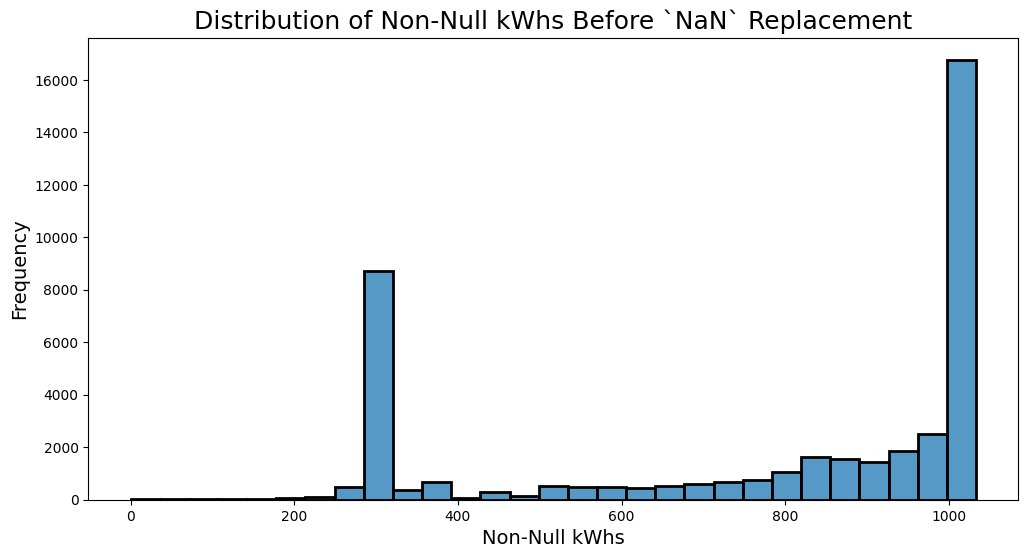

In [19]:
# Using a distribution plot to visualize non-null counts in data
plt.figure(figsize=(12, 6))
sns.histplot(non_null_counts_by_consumer, kde=False, edgecolor='k', linewidth=2)
plt.xlabel('Non-Null kWhs', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Non-Null kWhs Before `NaN` Replacement', fontsize=18)

In [43]:
# Making a deep copy so that I don't modify the original dataset
df_missing_replaced = sorted_df.copy(deep=True)

# Getting the number of consumers and kWhs 
NUM_CONSUMERS, NUM_DAYS = sorted_df.shape
print(f"Number of consumers (rows): {NUM_CONSUMERS}\nNumber of days (columns): {NUM_DAYS - 2}")
df_missing_replaced

Number of consumers (rows): 42372
Number of days (columns): 1034


,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,15.15,19.28,17.19,16.80,17.48,17.86,23.99,...,15.64,16.48,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39


In [40]:
# Attempting numpy array-based solution
kWhs = sorted_df.iloc[:, 2:].values

# Does it have the right shape
rows, cols = kWhs.shape

# Record time at beginning of loop
t_0 = time.time()

# For every consumer
for i in range(0, rows):
  # Print a dot as an update after every 400 consumers
  if (i % 400  == 0):
    print(".", end="")

  # And for every value of that consumer
  for j in range(1, cols - 1):
    # If the current value is undefined
    if (np.isnan(kWhs[i, j])):
      if (~np.isnan(kWhs[i, j - 1]) and ~np.isnan(kWhs[i, j + 1])):
        kWhs[i, j] = np.mean([kWhs[i, j - 1], kWhs[i, j + 1]])
      elif(np.isnan(kWhs[i, j - 1]) or np.isnan(kWhs[i, j + 1])):
        kWhs[i, j] = 0.0

# Record time at end of loop
t_f = time.time()
print((t_f - t_0)/60)

..........................................................................................................1.8710193792978922


In [47]:
# Replacing kWh values with processed numpy array values in the dataframe
df_missing_replaced.iloc[:, 2:] = kWhs

# Remaining `NaN`s are in the first and last columns - replace with 0
df_missing_replaced.fillna(0, inplace=True)

# Confirming `NaNs` have been replaced in the head
df_missing_replaced

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,15.15,19.28,17.19,16.80,17.48,17.86,23.99,...,15.64,16.48,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39


In [54]:
sorted_vals_unraveled = sorted_df.iloc[:, 2:].values.ravel()

# Remove all the NaNs from this array of kWh values
sorted_vals_filtered = sorted_vals_unraveled[~np.isnan(sorted_vals_unraveled)]

np.any(np.isnan(sorted_vals_filtered))

False

## Another way

In [48]:
# Step 2: Detect and remove rows with more than 600 NaNs
df_missing = sorted_df.copy(deep=True)
threshold = 600  # Set the threshold for NaN values
rows_to_drop = df_missing[df_missing.isnull().sum(axis=1) > threshold].index  # Get index of rows with more than 600 NaNs

# Step 3: Remove these rows from the DataFrame
df_cleaned = df_missing.drop(index=rows_to_drop)
df_cleaned

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
3,B32AC8CC6D5D805AC053557AB05F5343,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
6,34C1954AA3703C4F8BD8EAEA7C4B7B83,1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
7,768309B0EB11FD436CEE5ABFB84F4C0C,1,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42366,5FCE503B6B616D5023B3C46173383107,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
42367,F1472871E1AFF49D4289564B6377D76C,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


In [50]:
# Method 1
# Apply the linear interpolation method
# Assuming df is your DataFrame
for col in df_cleaned.columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
df_interpolated = df_cleaned.interpolate(method='linear', axis=1, limit_direction='both')
# Replace NaN values with 0 where interpolation couldn't be applied
df_filled = df_cleaned.fillna(0)

df_filled


,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
3,0.0,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,0.0,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
6,0.0,1,0.11,0.11,0.25,0.27,0.21,0.20,0.14,0.34,...,1.85,3.36,1.45,2.12,1.55,1.18,1.13,1.34,1.26,1.40
7,0.0,1,0.91,1.16,0.75,1.30,0.74,0.94,0.85,1.21,...,3.55,3.22,3.06,3.97,2.79,3.82,2.75,2.96,3.67,2.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42366,0.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.59,0.95,0.39,0.86,0.60,0.82,0.65,0.53,0.77,0.56
42367,0.0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,0.0,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,0.0,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65


# Outliers handling

In [56]:
interpolated_data=df_missing_replaced.copy(deep=True)
interpolated_data.head()

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [57]:
interpolated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42372 entries, 0 to 42371
Columns: 1036 entries, CONS_NO to 2016-10-31
dtypes: float64(1034), int64(1), object(1)
memory usage: 336.2+ MB


In [58]:
# Extract only the kWhs
kWhs = interpolated_data.iloc[:, 2:]
kWhs.head()

,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,2014-01-09,2014-01-10,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,2.9,5.64,6.99,3.32,3.61,5.35,4.73,3.68,3.53,3.42,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72


In [59]:
# Making a copy of raw data prior to processing
kWhs_outliers_removed = kWhs.copy()

NUM_CONSUMERS, NUM_DAYS = kWhs_outliers_removed.shape
print(f"Number of consumers: {NUM_CONSUMERS}\nNumber of Days:{NUM_DAYS}")

# Compute means and standard deviations for all consumers
means_by_consumer = kWhs.mean(axis=1)
stds_by_consumer = kWhs.std(axis=1)

# Confirming that there is one mean and standard deviation per consumer
assert(len(means_by_consumer) == len(stds_by_consumer))
assert(len(means_by_consumer) == NUM_CONSUMERS)

Number of consumers: 42372
Number of Days:1034


In [60]:
# Use the mean and standard deviation to compute the threshold for each consumer
thresholds = means_by_consumer + 2 * stds_by_consumer

# Replacing outliers for each consumer 
for i in range(0, NUM_CONSUMERS, 1):
  # Update while processing by print a dot 
  if (i % 400 == 0):
    print("#", end="")

    # Compare each value (`kWh`) of each row (.iloc[i]) with its corresponding threshold
    # If exceeds threshold, replace with threshold. Otherwise, leave unchanged
    # Lambda expression + apply for faster code
    kWhs_outliers_removed.iloc[i] = kWhs_outliers_removed.iloc[i].apply(lambda kWh : thresholds[i] if kWh > thresholds[i] else kWh)

##########################################################################################################

In [65]:
outliersRemoved = kWhs_outliers_removed.copy()
outliersRemoved.insert(0, 'CONS_NO', df_missing_replaced[['CONS_NO']])
outliersRemoved.insert(1, 'FLAG', df_missing_replaced[['FLAG']])

outliersRemoved

,CONS_NO,FLAG,2014-01-01,2014-01-02,2014-01-03,2014-01-04,2014-01-05,2014-01-06,2014-01-07,2014-01-08,...,2016-10-22,2016-10-23,2016-10-24,2016-10-25,2016-10-26,2016-10-27,2016-10-28,2016-10-29,2016-10-30,2016-10-31
0,0387DD8A07E07FDA6271170F86AD9151,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,7.18,8.07,8.09,9.53,5.48,8.75,9.30,7.54,9.16,6.74
1,01D6177B5D4FFE0CABA9EF17DAFC2B84,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,4B75AC4F2D8434CFF62DB64D0BB43103,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,10.95,17.95,17.83,17.31,21.44,19.09,18.56,16.25,14.20,13.66
3,B32AC8CC6D5D805AC053557AB05F5343,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,12.81,15.12,17.26,14.91,19.59,20.79,17.95,19.26,14.46,11.72
4,EDFC78B07BA2908B3395C4EB2304665E,1,2.90,5.64,6.99,3.32,3.61,5.35,4.73,3.68,...,14.21,10.22,8.47,6.11,6.10,6.73,7.52,10.89,9.86,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42367,F1472871E1AFF49D4289564B6377D76C,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.27,3.10,2.75,3.01,2.99,2.83,2.54,3.40,3.59,2.54
42368,F3C8BBCD2DC26C1E0249DEEF6A4256B7,0,2.70,0.00,0.00,5.72,6.05,5.81,3.07,4.04,...,3.84,6.62,3.12,5.16,3.62,4.64,3.71,6.22,6.05,4.77
42369,A9A0FE83467A680FBFB0DBFC910DF227,0,0.58,1.16,0.92,0.98,1.54,1.38,0.89,0.70,...,0.99,0.61,0.65,0.55,0.49,0.51,0.79,0.66,0.39,0.65
42370,D9A6ADA018FA46A55D5438370456AA45,0,16.89,15.15,19.28,17.19,16.80,17.48,17.86,23.99,...,15.64,16.48,13.04,10.39,12.00,11.15,12.22,13.16,13.33,10.39


In [ ]:
temp = outliersRemoved.iloc[:, 2:]
mask = temp > 100000

print(temp[mask].values[np.where(mask)])

[514991.78 233696.4  466714.4  400001.66 800003.32 400003.33 640000.
 653502.79 326753.54 554535.44 277267.72]


## Another data preprocessing

In [239]:
df_pr = df_filled.drop(['index','FLAG'], axis = 1)
df_pr = df_pr * 100
df_pr = df_pr.astype(int)
df_pr

,2014/1/1,2014/1/10,2014/1/11,2014/1/12,2014/1/13,2014/1/14,2014/1/15,2014/1/16,2014/1/17,2014/1/18,...,2016/9/28,2016/9/29,2016/9/3,2016/9/30,2016/9/4,2016/9/5,2016/9/6,2016/9/7,2016/9/8,2016/9/9
CONS_NO,,,,,,,,,,,,,,,,,,,,,
0387DD8A07E07FDA6271170F86AD9151,0,0,0,0,0,0,0,0,0,0,...,1011,996,1692,760,2722,1805,2647,1875,1784,1492
B32AC8CC6D5D805AC053557AB05F5343,0,0,0,0,0,0,0,0,0,0,...,650,999,1178,1859,2680,1857,1459,1282,1937,1592
EDFC78B07BA2908B3395C4EB2304665E,290,342,381,458,356,425,386,353,341,85,...,1777,1037,1532,1351,1223,1468,1635,1814,1841,1730
34C1954AA3703C4F8BD8EAEA7C4B7B83,11,53,45,51,132,71,12,52,55,74,...,433,246,123,319,117,136,56,102,196,183
768309B0EB11FD436CEE5ABFB84F4C0C,91,86,110,66,582,317,118,405,366,321,...,236,282,227,370,307,461,313,310,374,313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5FCE503B6B616D5023B3C46173383107,0,0,0,0,0,0,0,0,0,0,...,49,77,0,64,0,129,67,76,115,40
F1472871E1AFF49D4289564B6377D76C,0,0,0,0,0,0,0,0,0,0,...,425,356,338,438,372,377,396,364,340,438
F3C8BBCD2DC26C1E0249DEEF6A4256B7,270,438,395,0,0,0,0,0,0,0,...,480,487,448,367,331,458,333,319,457,400


In [242]:
#df_pr['data'] = df_pr[df_pr.columns].astype(float).values.tolist()
df_pr['data'] = df_pr[df_pr.columns].values.tolist()
df_apr = df_pr['data']
df_apr

CONS_NO
0387DD8A07E07FDA6271170F86AD9151    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
B32AC8CC6D5D805AC053557AB05F5343    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
EDFC78B07BA2908B3395C4EB2304665E    [290, 342, 381, 458, 356, 425, 386, 353, 341, ...
34C1954AA3703C4F8BD8EAEA7C4B7B83    [11, 53, 45, 51, 132, 71, 12, 52, 55, 74, 92, ...
768309B0EB11FD436CEE5ABFB84F4C0C    [91, 86, 110, 66, 582, 317, 118, 405, 366, 321...
                                                          ...                        
5FCE503B6B616D5023B3C46173383107    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
F1472871E1AFF49D4289564B6377D76C    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
F3C8BBCD2DC26C1E0249DEEF6A4256B7    [270, 438, 395, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
A9A0FE83467A680FBFB0DBFC910DF227    [57, 84, 161, 90, 60, 82, 89, 3, 73, 168, 127,...
D9A6ADA018FA46A55D5438370456AA45    [1689, 1384, 1350, 1460, 1446, 1234, 1537, 170...
Name: data, Length: 31683, dtype: object

In [366]:
window_size = 28 # 4weeks
output_shape = (1035 // window_size, window_size)
print(output_shape)
strided_size = output_shape[0]
print(strided_size)

# print(np.arange(20))
# np.lib.stride_tricks.as_strided(np.arange(30), (6,5), (8*5, 8))

def stride(x):
    as_strided = np.lib.stride_tricks.as_strided
    x = pd.Series(x)
    return as_strided(x, output_shape, (8*window_size, 8))
data = df_apr.apply(stride)
data

(36, 28)
36


CONS_NO
0387DD8A07E07FDA6271170F86AD9151    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
B32AC8CC6D5D805AC053557AB05F5343    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
EDFC78B07BA2908B3395C4EB2304665E    [[290, 342, 381, 458, 356, 425, 386, 353, 341,...
34C1954AA3703C4F8BD8EAEA7C4B7B83    [[11, 53, 45, 51, 132, 71, 12, 52, 55, 74, 92,...
768309B0EB11FD436CEE5ABFB84F4C0C    [[91, 86, 110, 66, 582, 317, 118, 405, 366, 32...
                                                          ...                        
5FCE503B6B616D5023B3C46173383107    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
F1472871E1AFF49D4289564B6377D76C    [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
F3C8BBCD2DC26C1E0249DEEF6A4256B7    [[270, 438, 395, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
A9A0FE83467A680FBFB0DBFC910DF227    [[57, 84, 161, 90, 60, 82, 89, 3, 73, 168, 127...
D9A6ADA018FA46A55D5438370456AA45    [[1689, 1384, 1350, 1460, 1446, 1234, 1537, 17...
Name: data, Length: 31683, dtype: object

In [368]:
for i in range(len(data)):
    mask = data[i] > 10000000
    if mask.any():
        print(data[i][np.where(mask)])

[51499178]
[46671440]
[80000332]
[64000000]
[65350279]
[55453543]


In [374]:
df_dpr = data.to_frame()
df_dpr['label'] = df_filled['FLAG']
df_dpr['data'][0]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 2626, 2287, 2243, 2528, 2117, 2044, 2068, 2114,
        2016, 1997, 2189, 2508, 2196, 2252, 2090, 2028, 2005, 2093, 2193,
        2101, 2230, 1925,    0, 2440, 4642],
       [2291, 2348, 2298, 2327, 2268, 2298, 3826, 1855, 2248, 1894, 2231,
        2065, 1861, 2237, 1996, 1832, 1759, 2193, 1814, 1779, 1188,  607,
         624,  554,  645,  542,  601,  579],
       [2036,  641, 2052, 2072, 1961, 1864, 2039, 2165,  558,  611,  669,
         616,  648,  694,  580,  653,    0,    0,    0,  678,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,  549,    0,    0,  683,  694,  624,  744,  569,  657,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    

In [375]:
data_dir = '../data'
save_file = f'{data_dir}/data_100.npz'
print('Saving to: ', save_file)
data = df_dpr['data']
label = df_dpr['label']
np.savez_compressed(save_file, data=data, label=label)

Saving to:  ../data/data_100.npz


In [376]:
np.random.seed(0)

class Writer:
    def __init__(self, outdir, type_name, start_idx=0,):
        self.outdir = Path(outdir)/ type_name
        self.outdir.mkdir(parents=True, exist_ok=True)
        self.idx = start_idx
    def write(self, X, y):
        save_file = self.outdir / f'{self.idx}.npz'
        np.savez_compressed(save_file, X=X, y=y)
        self.idx += 1
    def start(self):
        print('Start writing to: ', self.outdir)

def write_to_file(writer, X, y):
    writer.start()
    try:
        for xi, yi in tqdm(zip(X, y)):
            writer.write(xi, yi)
    except: return False
    return True

def train_test_split(N, test_fraction):
    """
    Input: 
    N: the size of the dataset
    test_fraction: the portion for test set
    Output:
    Return the index for train, val, and test set
    """
    test_size = int(N * test_fraction)
    indices = np.random.permutation(N) 
    test_idx = indices[:test_size]
    train_idx = indices[test_size:]
    return [train_idx, test_idx]

def create_folder_from_npz_file(out_dir, dir_type, fn):
    file_name = Path(data_dir) / fn
    print('Loading from: ', file_name)
    df_np = np.load(file_name, allow_pickle=True)
    print(df_np.files)
    data, label = df_np['data'], df_np['label']
    print(len(data), len(label))
    np.set_printoptions(threshold=np.inf)
    print(data[0])
    
    indices_lists = train_test_split(len(data), test_fraction=0.2) 
    prefix = ['train', 'test']
    
    for prefix, indices in zip(prefix, indices_lists):
        if prefix == dir_type:
            print(f'{prefix} size: ', len(indices))
            data_subset = data[indices] 
            label_subset = label[indices]

    out_path = out_dir  
    writer = Writer(outdir=out_path, type_name=f'{dir_type}')
    return write_to_file(writer, data_subset, label_subset)


out_dir = '../data/m100/'
create_folder_from_npz_file(out_dir=out_dir, dir_type='train', fn='data_100.npz')
create_folder_from_npz_file(out_dir=out_dir, dir_type='test', fn='data_100.npz')

Loading from:  ../data/data_100.npz
['data', 'label']
31683 31683
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0 2626 2287 2243 2528 2117 2044 2068 2114 2016 1997 2189
  2508 2196 2252 2090 2028 2005 2093 2193 2101 2230 1925    0 2440 4642]
 [2291 2348 2298 2327 2268 2298 3826 1855 2248 1894 2231 2065 1861 2237
  1996 1832 1759 2193 1814 1779 1188  607  624  554  645  542  601  579]
 [2036  641 2052 2072 1961 1864 2039 2165  558  611  669  616  648  694
   580  653    0    0    0  678    0    0    0    0    0    0    0    0]
 [   0    0  549    0    0  683  694  624  744  569  657    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  641  668
   715  600  501  689  691  826  555  537  830  472  656  494  789  508]
 [ 657  520  478  446  490  757  608  659  701  761  810  454  7

25347it [00:14, 1720.88it/s]


Loading from:  ../data/data_100.npz
['data', 'label']
31683 31683
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0 2626 2287 2243 2528 2117 2044 2068 2114 2016 1997 2189
  2508 2196 2252 2090 2028 2005 2093 2193 2101 2230 1925    0 2440 4642]
 [2291 2348 2298 2327 2268 2298 3826 1855 2248 1894 2231 2065 1861 2237
  1996 1832 1759 2193 1814 1779 1188  607  624  554  645  542  601  579]
 [2036  641 2052 2072 1961 1864 2039 2165  558  611  669  616  648  694
   580  653    0    0    0  678    0    0    0    0    0    0    0    0]
 [   0    0  549    0    0  683  694  624  744  569  657    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0  641  668
   715  600  501  689  691  826  555  537  830  472  656  494  789  508]
 [ 657  520  478  446  490  757  608  659  701  761  810  454  7

6336it [00:03, 1670.29it/s]


True